## Imports and Setup

In [2]:
import os, random, math, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Reproducibility
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# ML & utils
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, confusion_matrix, classification_report)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# For saving results
import joblib
from pathlib import Path

# Output directories
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / 'data'
OUT_DIR = BASE_DIR / 'outputs'
FIG_DIR = OUT_DIR / 'figures'
RES_DIR = OUT_DIR / 'results'
for d in [OUT_DIR, FIG_DIR, RES_DIR]:
    os.makedirs(d, exist_ok=True)

print("Project base:", BASE_DIR)
print("Data folder:", DATA_DIR)
print("Outputs folder:", OUT_DIR)

Project base: /home/rabby/Desktop/5th Semester/New Technology Special Topic/Test 1 (Copy)
Data folder: /home/rabby/Desktop/5th Semester/New Technology Special Topic/Test 1 (Copy)/data
Outputs folder: /home/rabby/Desktop/5th Semester/New Technology Special Topic/Test 1 (Copy)/outputs


## Data Load & EDA

In [5]:
# load dataset
df = pd.read_csv("data/heart-disease-UCI.csv")
print("Shape:", df.shape)

Shape: (303, 14)


In [7]:
display(df.head())

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [9]:
# Let's see how many positive (1) and negative (0) samples we have in our dataframe
df.target.value_counts()

target
1    165
0    138
Name: count, dtype: int64

In [11]:
# Normalized value counts
df.target.value_counts(normalize=True)

target
1    0.544554
0    0.455446
Name: proportion, dtype: float64

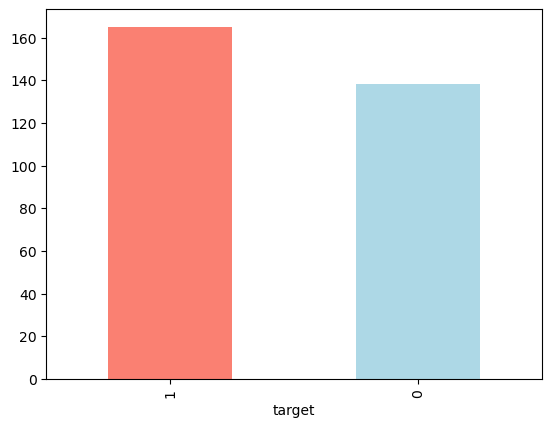

In [13]:
# Plot the value counts with a bar graph
df.target.value_counts().plot(kind="bar", color=["salmon", "lightblue"]);

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trestbps  303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalach   303 non-null    int64  
 8   exang     303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slope     303 non-null    int64  
 11  ca        303 non-null    int64  
 12  thal      303 non-null    int64  
 13  target    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


In [17]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


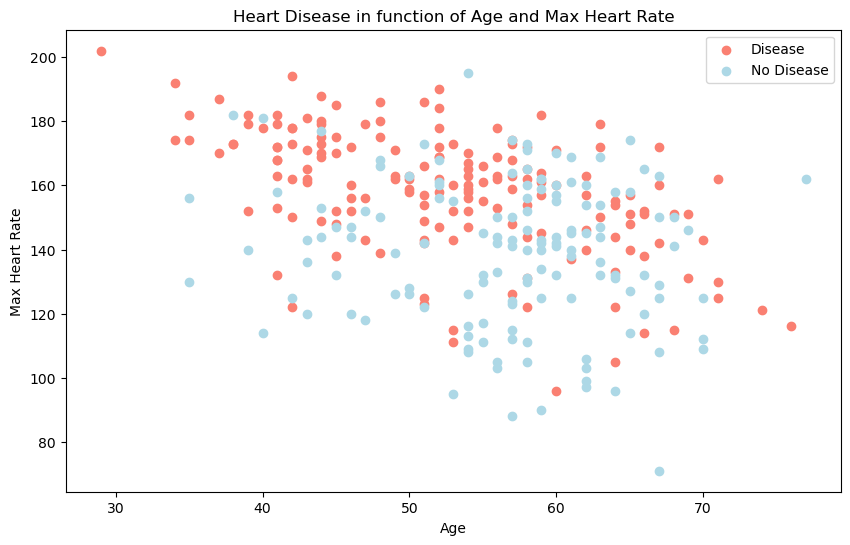

In [19]:
# Create another figure
plt.figure(figsize=(10,6))

# Start with positve examples
plt.scatter(df.age[df.target==1], 
            df.thalach[df.target==1], 
            c="salmon") # define it as a scatter figure

# Now for negative examples, we want them on the same plot, so we call plt again
plt.scatter(df.age[df.target==0], 
            df.thalach[df.target==0], 
            c="lightblue") # axis always come as (x, y)

# Add some helpful info
plt.title("Heart Disease in function of Age and Max Heart Rate")
plt.xlabel("Age")
plt.legend(["Disease", "No Disease"])
plt.ylabel("Max Heart Rate");

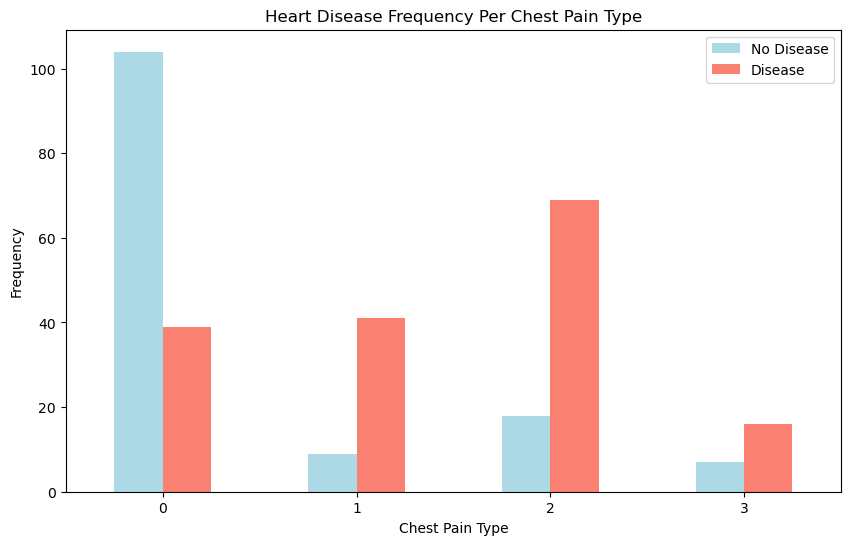

In [21]:
# Create a new crosstab and base plot
pd.crosstab(df.cp, df.target).plot(kind="bar", 
                                   figsize=(10,6), 
                                   color=["lightblue", "salmon"])

# Add attributes to the plot to make it more readable
plt.title("Heart Disease Frequency Per Chest Pain Type")
plt.xlabel("Chest Pain Type")
plt.ylabel("Frequency")
plt.legend(["No Disease", "Disease"])
plt.xticks(rotation = 0);

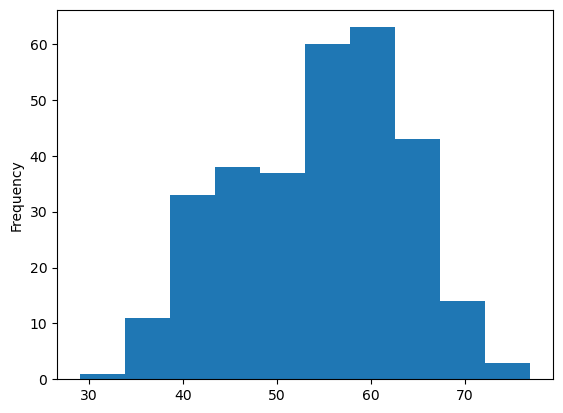

In [23]:
# Histograms are a great way to check the distribution of a variable
df.age.plot.hist();

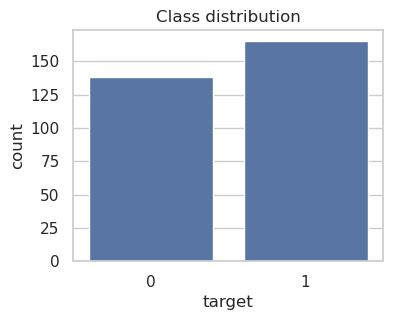

In [32]:
# class count
target_col = 'target'
plt.figure(figsize=(4,3))
sns.countplot(x=target_col, data=df)
plt.title("Class distribution")
plt.savefig(FIG_DIR / "class_distribution.png", bbox_inches='tight')
plt.show()

Numeric columns: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


<Figure size 1200x800 with 0 Axes>

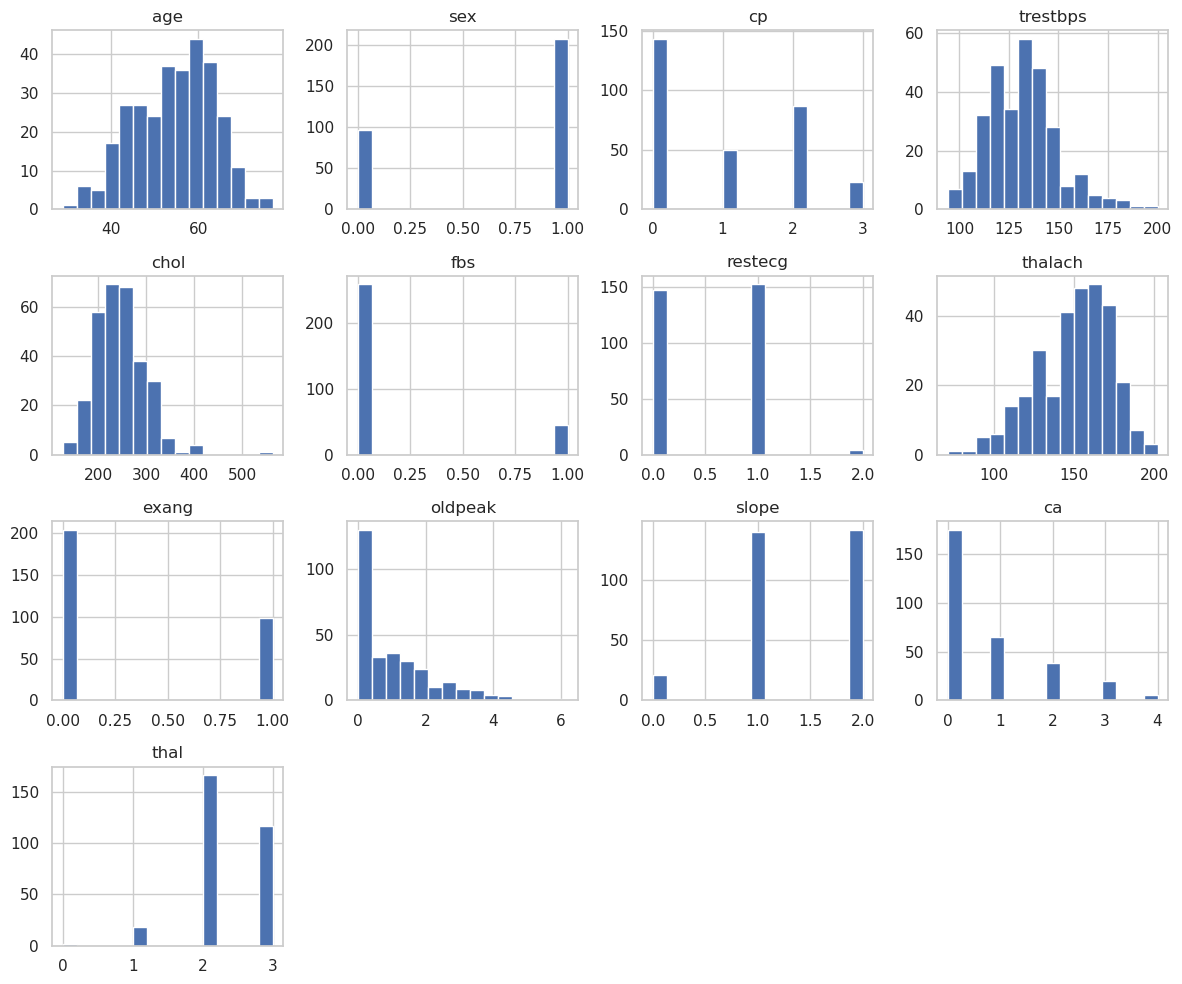

In [34]:
# numeric feature histograms (select numeric cols)
numeric_cols = df.select_dtypes(include=['int64','float64']).columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_col]
print("Numeric columns:", numeric_cols)

plt.figure(figsize=(12,8))
df[numeric_cols].hist(bins=15, figsize=(12,10))
plt.tight_layout()
plt.savefig(FIG_DIR / "numeric_histograms.png")
plt.show()

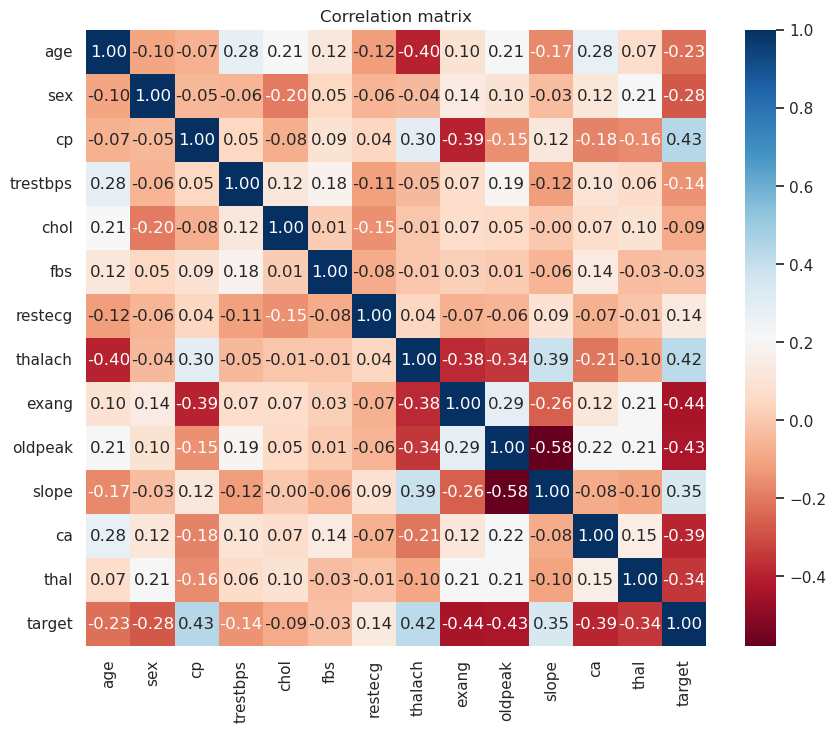

In [36]:
# correlation heatmap for numeric features
plt.figure(figsize=(10,8))
sns.heatmap(df[numeric_cols + [target_col]].corr(), annot=True, fmt=".2f", cmap="RdBu")
plt.title("Correlation matrix")
plt.savefig(FIG_DIR / "correlation_matrix.png", bbox_inches='tight')
plt.show()

In [38]:
# checking the percentage of missing values
(df.isna().sum()/len(df) *100).round(2).sort_values(ascending=False)

age         0.0
sex         0.0
cp          0.0
trestbps    0.0
chol        0.0
fbs         0.0
restecg     0.0
thalach     0.0
exang       0.0
oldpeak     0.0
slope       0.0
ca          0.0
thal        0.0
target      0.0
dtype: float64

In [40]:
# Cell 5: identify categorical columns (common in UCI heart)
possible_cat = ['cp','thal','slope','restecg','sex','fbs','exang','ca']  # adjust if missing
cat_cols = [c for c in possible_cat if c in df.columns]
num_cols = [c for c in df.columns if c not in cat_cols + [target_col]]
print("Categorical columns detected:", cat_cols)
print("Numeric columns detected:", num_cols)

Categorical columns detected: ['cp', 'thal', 'slope', 'restecg', 'sex', 'fbs', 'exang', 'ca']
Numeric columns detected: ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']


## Build preprocessing pipeline

In [43]:
# preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))  # Use sparse_output instead
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ], remainder='passthrough'  # if any unexpected cols remain
)

# test transformation shape (fit on full data to inspect - later fit on train only)
preprocessor.fit(df.drop(columns=[target_col]))
sample = preprocessor.transform(df.drop(columns=[target_col])).shape
print("Preprocessed feature matrix shape (sample):", sample)

Preprocessed feature matrix shape (sample): (303, 30)


## Train-test split (stratified) and fit preprocessor on train

In [46]:
#  train-test split (stratified)
X = df.drop(columns=[target_col])
y = df[target_col]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train class counts:", y_train.value_counts().to_dict())
print("Test class counts:", y_test.value_counts().to_dict())

# Fit preprocessor on training data only
preprocessor.fit(X_train)
X_train_prep = preprocessor.transform(X_train)
X_test_prep = preprocessor.transform(X_test)

print("Prepared train shape:", X_train_prep.shape, "Prepared test shape:", X_test_prep.shape)

Train shape: (242, 13) Test shape: (61, 13)
Train class counts: {1: 132, 0: 110}
Test class counts: {1: 33, 0: 28}
Prepared train shape: (242, 30) Prepared test shape: (61, 30)


## Helper: evaluation function & results container

In [49]:
# evaluation helper
from sklearn.metrics import precision_recall_fscore_support

def compute_metrics(y_true, y_pred, y_proba=None):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    auc = roc_auc_score(y_true, y_proba) if y_proba is not None else np.nan
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0.0
    return dict(accuracy=acc, precision=prec, recall=rec, f1=f1, auc=auc, specificity=specificity, cm=cm)

results = []  # will append dicts

## Baseline model: Logistic Regression

In [52]:
# Logistic Regression baseline
pipe_lr = Pipeline([('pre', preprocessor),
                    ('clf', LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))])
pipe_lr.fit(X_train, y_train)
y_pred = pipe_lr.predict(X_test)
y_proba = pipe_lr.predict_proba(X_test)[:,1]

m_lr = compute_metrics(y_test, y_pred, y_proba)
m_lr['model'] = 'LogisticRegression'
results.append(m_lr)
print("Logistic Regression metrics:", {k: v for k, v in m_lr.items() if k!='cm'})
print("Confusion matrix:\n", m_lr['cm'])

Logistic Regression metrics: {'accuracy': 0.8688524590163934, 'precision': 0.8571428571428571, 'recall': 0.9090909090909091, 'f1': 0.8823529411764706, 'auc': 0.9101731601731602, 'specificity': 0.8214285714285714, 'model': 'LogisticRegression'}
Confusion matrix:
 [[23  5]
 [ 3 30]]


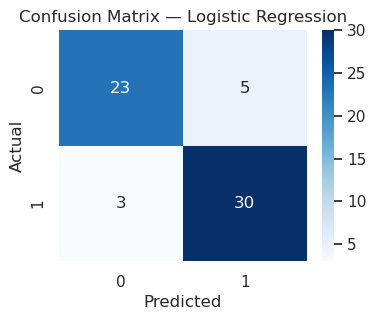

,Metric,Value
0,Accuracy,0.868852
1,Precision,0.857143
2,Recall,0.909091
3,F1-score,0.882353
4,ROC-AUC,0.910173
5,Specificity,0.821429


Saved logistic_regression_metrics.csv


In [54]:
# Visualization: Confusion Matrix for Logistic Regression
cm = m_lr['cm']
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix — Logistic Regression")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(FIG_DIR / "cm_logistic_regression.png", bbox_inches='tight')
plt.show()

# Metrics table for Logistic Regression
lr_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'Specificity'],
    'Value': [
        m_lr['accuracy'], m_lr['precision'], m_lr['recall'],
        m_lr['f1'], m_lr['auc'], m_lr['specificity']
    ]
})
display(lr_table)

lr_table.to_csv(RES_DIR / "logistic_regression_metrics.csv", index=False)
print("Saved logistic_regression_metrics.csv")

## Baseline model: KNN (k=5)

In [57]:
# Cell 10: KNN baseline k=5
pipe_knn = Pipeline([('pre', preprocessor),
                     ('clf', KNeighborsClassifier(n_neighbors=5))])
pipe_knn.fit(X_train, y_train)
y_pred = pipe_knn.predict(X_test)
# KNN has no predict_proba for some versions; use if available
y_proba = pipe_knn.predict_proba(X_test)[:,1] if hasattr(pipe_knn, "predict_proba") else None

m_knn = compute_metrics(y_test, y_pred, y_proba)
m_knn['model'] = 'KNN_k5'
results.append(m_knn)
print("KNN metrics:", {k: v for k, v in m_knn.items() if k!='cm'})
print("Confusion matrix:\n", m_knn['cm'])

KNN metrics: {'accuracy': 0.7704918032786885, 'precision': 0.7567567567567568, 'recall': 0.8484848484848485, 'f1': 0.8, 'auc': 0.8690476190476191, 'specificity': 0.6785714285714286, 'model': 'KNN_k5'}
Confusion matrix:
 [[19  9]
 [ 5 28]]


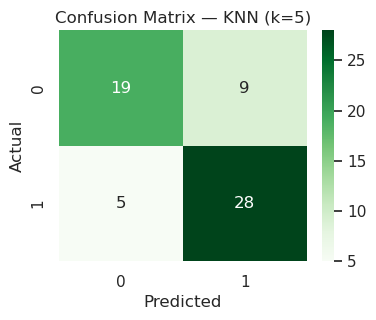

In [59]:
# Visualization: Confusion Matrix for KNN
cm = m_knn['cm']
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix — KNN (k=5)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(FIG_DIR / "cm_knn_k5.png", bbox_inches='tight')
plt.show()

## Baseline model: Decision Tree

In [62]:
# Decision Tree baseline
pipe_dt = Pipeline([('pre', preprocessor),
                    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))])
pipe_dt.fit(X_train, y_train)
y_pred = pipe_dt.predict(X_test)
y_proba = pipe_dt.predict_proba(X_test)[:,1] if hasattr(pipe_dt, "predict_proba") else None

m_dt = compute_metrics(y_test, y_pred, y_proba)
m_dt['model'] = 'DecisionTree'
results.append(m_dt)
print("Decision Tree metrics:", {k: v for k, v in m_dt.items() if k!='cm'})
print("Confusion matrix:\n", m_dt['cm'])

Decision Tree metrics: {'accuracy': 0.7213114754098361, 'precision': 0.7352941176470589, 'recall': 0.7575757575757576, 'f1': 0.746268656716418, 'auc': 0.7180735930735931, 'specificity': 0.6785714285714286, 'model': 'DecisionTree'}
Confusion matrix:
 [[19  9]
 [ 8 25]]


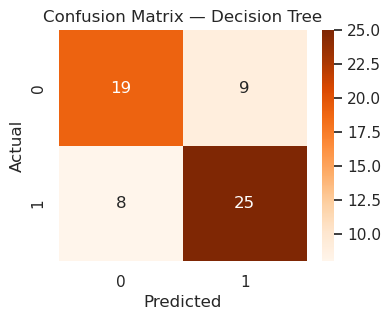

In [64]:
# Visualization: Confusion Matrix for Decision Tree
cm = m_dt['cm']
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix — Decision Tree")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(FIG_DIR / "cm_decision_tree.png", bbox_inches='tight')
plt.show()

## Baseline model: ANN (Keras small net)

In [67]:
# ANN baseline (keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Convert prepared arrays to numpy arrays
X_train_np = X_train_prep.astype(float)
X_test_np = X_test_prep.astype(float)

def build_ann(input_dim):
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.2))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

input_dim = X_train_np.shape[1]
ann = build_ann(input_dim)
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history = ann.fit(X_train_np, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)

# predictions and metrics
y_proba_ann = ann.predict(X_test_np).ravel()
y_pred_ann = (y_proba_ann >= 0.5).astype(int)

m_ann = compute_metrics(y_test, y_pred_ann, y_proba_ann)
m_ann['model'] = 'ANN'
results.append(m_ann)
print("ANN metrics:", {k: v for k, v in m_ann.items() if k!='cm'})

/home/rabby/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.5300 - loss: 0.6965 - val_accuracy: 0.7200 - val_loss: 0.6549
Epoch 2/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6452 - loss: 0.6607 - val_accuracy: 0.7600 - val_loss: 0.6094
Epoch 3/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7189 - loss: 0.6136 - val_accuracy: 0.7600 - val_loss: 0.5460
Epoch 4/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7235 - loss: 0.5870 - val_accuracy: 0.7600 - val_loss: 0.4838
Epoch 5/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7465 - loss: 0.5480 - val_accuracy: 0.8000 - val_loss: 0.4236
Epoch 6/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7742 - loss: 0.5120 - val_accuracy: 0.8800 - val_loss: 0.3826
Epoch 7/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8065 - loss: 0.4734 - val_accuracy: 0.9200 - val_loss: 0.3395
Epoch 8/50
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8249 - loss: 0.4466 - val_accuracy: 0.9200 - val_l

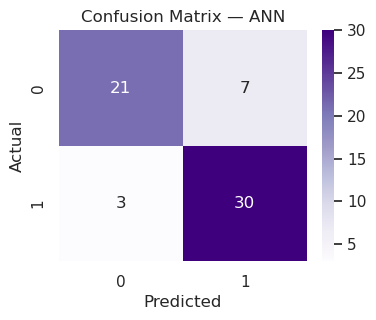

In [69]:
# Visualization: Confusion Matrix for ANN
cm = m_ann['cm']
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples')
plt.title("Confusion Matrix — ANN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(FIG_DIR / "cm_ann.png", bbox_inches='tight')
plt.show()

## Deep learning networks(DNN)

In [72]:
# Cell 13: DNN (deeper) - optional, run only if resources permit
def build_dnn(input_dim):
    model = Sequential()
    model.add(Dense(64, activation='relu', input_shape=(input_dim,)))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

dnn = build_dnn(input_dim)
es2 = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
history2 = dnn.fit(X_train_np, y_train, epochs=80, batch_size=16, validation_split=0.1, verbose=1)

y_proba_dnn = dnn.predict(X_test_np).ravel()
y_pred_dnn = (y_proba_dnn >= 0.5).astype(int)
m_dnn = compute_metrics(y_test, y_pred_dnn, y_proba_dnn)
m_dnn['model'] = 'DNN'
results.append(m_dnn)
print("DNN metrics:", {k: v for k, v in m_dnn.items() if k!='cm'})
print("Confusion matrix:\n", m_dnn['cm'])

Epoch 1/80


/home/rabby/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.5899 - loss: 0.6710 - val_accuracy: 0.8400 - val_loss: 0.6372
Epoch 2/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7465 - loss: 0.6127 - val_accuracy: 0.9600 - val_loss: 0.5529
Epoch 3/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7972 - loss: 0.5570 - val_accuracy: 0.9600 - val_loss: 0.4364
Epoch 4/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.7834 - loss: 0.5087 - val_accuracy: 0.9600 - val_loss: 0.3270
Epoch 5/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8111 - loss: 0.4327 - val_accuracy: 0.9600 - val_loss: 0.2216
Epoch 6/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8387 - loss: 0.3967 - val_accuracy: 0.9600 - val_loss: 0.1853
Epoch 7/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8341 - loss: 0.3726 - val_accuracy: 0.9600 - val_loss: 0.1607
Epoch 8/80
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8618 - loss: 0.3459 - val_accuracy: 0.9600 - val_loss: 0.15

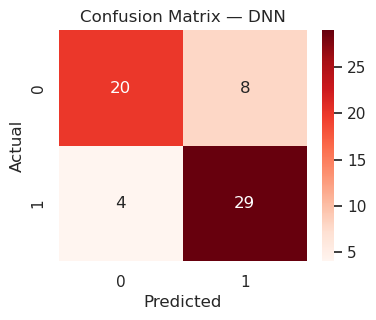

In [74]:
# Visualization: Confusion Matrix for DNN
cm = m_dnn['cm']
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.title("Confusion Matrix — DNN")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.savefig(FIG_DIR / "cm_dnn.png", bbox_inches='tight')
plt.show()

In [80]:
# summarize results
df_results = pd.DataFrame(results).set_index('model')
display(df_results)
df_results.to_csv(RES_DIR / "baseline_results.csv")
print("Saved baseline_results.csv ->", RES_DIR / "baseline_results.csv")

,accuracy,precision,recall,f1,auc,specificity,cm
model,,,,,,,
LogisticRegression,0.868852,0.857143,0.909091,0.882353,0.910173,0.821429,"[[23, 5], [3, 30]]"
KNN_k5,0.770492,0.756757,0.848485,0.800000,0.869048,0.678571,"[[19, 9], [5, 28]]"
DecisionTree,0.721311,0.735294,0.757576,0.746269,0.718074,0.678571,"[[19, 9], [8, 25]]"
ANN,0.836066,0.810811,0.909091,0.857143,0.896104,0.750000,"[[21, 7], [3, 30]]"
DNN,0.803279,0.783784,0.878788,0.828571,0.857143,0.714286,"[[20, 8], [4, 29]]"


Saved baseline_results.csv -> /home/rabby/Desktop/5th Semester/New Technology Special Topic/Test 1 (Copy)/outputs/results/baseline_results.csv


## parameter sweeps (KNN k and LR C) using cross_val_score

In [83]:
# parameter sweeps (KNN k and LR C) using cross_val_score
from sklearn.model_selection import cross_val_score

# KNN k sweep
k_values = [3,5,7,9]
knn_scores = []
for k in k_values:
    pipe = Pipeline([('pre', preprocessor), ('clf', KNeighborsClassifier(n_neighbors=k))])
    sc = cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE), scoring='f1')
    knn_scores.append(sc)
    print(f"K={k} | F1 mean={sc.mean():.3f} ± {sc.std():.3f}")

# LR C sweep
C_values = [0.01, 0.1, 1, 10]
lr_scores = []
for C in C_values:
    pipe = Pipeline([('pre', preprocessor), ('clf', LogisticRegression(C=C, max_iter=1000, random_state=RANDOM_STATE))])
    sc = cross_val_score(pipe, X_train, y_train, cv=StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE), scoring='f1')
    lr_scores.append(sc)
    print(f"C={C} | F1 mean={sc.mean():.3f} ± {sc.std():.3f}")

# Save sweep summary to CSV
sweep_df = pd.DataFrame({
    'k': [k for k in k_values for _ in [0]],
    'knn_f1_mean': [np.mean(s) for s in knn_scores],
    'knn_f1_std': [np.std(s) for s in knn_scores],
    'C': [None]*len(k_values),
})
sweep_df2 = pd.DataFrame({
    'C':C_values,
    'lr_f1_mean':[np.mean(s) for s in lr_scores],
    'lr_f1_std':[np.std(s) for s in lr_scores]
})
sweep_df2.to_csv(RES_DIR / "lr_sweep.csv", index=False)
print("Saved lr_sweep.csv")

K=3 | F1 mean=0.828 ± 0.053
K=5 | F1 mean=0.853 ± 0.036
K=7 | F1 mean=0.840 ± 0.041
K=9 | F1 mean=0.840 ± 0.054
C=0.01 | F1 mean=0.841 ± 0.071
C=0.1 | F1 mean=0.842 ± 0.061
C=1 | F1 mean=0.834 ± 0.051
C=10 | F1 mean=0.819 ± 0.062
Saved lr_sweep.csv


In [85]:
# save trained models (pickle)
joblib.dump(pipe_lr, RES_DIR / "pipe_lr.joblib")
joblib.dump(pipe_knn, RES_DIR / "pipe_knn.joblib")
joblib.dump(pipe_dt, RES_DIR / "pipe_dt.joblib")
print("Saved models to", RES_DIR)

Saved models to /home/rabby/Desktop/5th Semester/New Technology Special Topic/Test 1 (Copy)/outputs/results


In [87]:
# Cell 18: auto-generate comparison template text to paste into your report
paper_results = {
    'LogisticRegression': {'accuracy':93.40, 'precision':0.4589},
    'KNN_k5': {'accuracy':71.42, 'precision':0.4770},
    'DecisionTree': {'accuracy':81.31, 'precision':0.5},
    'ANN': {'accuracy':92.30, 'precision':0.4524},
    'DNN': {'accuracy':76.92, 'precision':0.5}
}

# Compose report table
rep_table = []
for model_name, res in paper_results.items():
    if model_name in df_results.index:
        my = df_results.loc[model_name]
        rep_table.append({
            'model': model_name,
            'paper_acc': paper_results[model_name]['accuracy'],
            'paper_prec': paper_results[model_name]['precision'],
            'my_acc': round(my['accuracy']*100, 2),
            'my_prec': round(my['precision'], 4),
            'my_recall': round(my['recall'], 4),
            'my_f1': round(my['f1'], 4),
            'my_auc': round(my['auc'], 4)
        })
    else:
        # If we didn't run a model exactly by that name, skip
        pass

comp_df = pd.DataFrame(rep_table).set_index('model')
display(comp_df)
comp_df.to_csv(RES_DIR / "paper_vs_reproduction.csv")
print("Saved paper_vs_reproduction.csv ->", RES_DIR / "paper_vs_reproduction.csv")

,paper_acc,paper_prec,my_acc,my_prec,my_recall,my_f1,my_auc
model,,,,,,,
LogisticRegression,93.40,0.4589,86.89,0.8571,0.9091,0.8824,0.9102
KNN_k5,71.42,0.4770,77.05,0.7568,0.8485,0.8000,0.8690
DecisionTree,81.31,0.5000,72.13,0.7353,0.7576,0.7463,0.7181
ANN,92.30,0.4524,83.61,0.8108,0.9091,0.8571,0.8961
DNN,76.92,0.5000,80.33,0.7838,0.8788,0.8286,0.8571


Saved paper_vs_reproduction.csv -> /home/rabby/Desktop/5th Semester/New Technology Special Topic/Test 1 (Copy)/outputs/results/paper_vs_reproduction.csv
